In [1]:
import sys
sys.path.append("../../pyASBC/src")
sys.path.append("../src")
import os
import re
from itertools import islice
from tqdm.auto import tqdm
import pyASBC
import opencc
from stanza.server import CoreNLPClient
from stanford_utils import *

In [2]:
os.environ["CORENLP_HOME"] = os.path.expanduser("~/etc/stanford-corenlp-4.4.0")
t2s = opencc.OpenCC('t2s.json')

In [3]:
import logging
logging.getLogger().setLevel("WARNING")

## Basic Stat

In [4]:
# iterate through all corpus, takes some time.
asbc = pyASBC.Asbc5Corpus("../../pyASBC/data/")
sum(1 for x in asbc.iter_characters())

15529165

## Testing

In [4]:
text = t2s.convert("分享給新進住民以及研究人員參考。")
# text = t2s.convert("我有一隻Ｊｏｈｎｎｙ貓")
with CoreNLPClient(properties="chinese",
        annotators=['tokenize','ssplit','pos','parse', 'depparse'],
        timeout=30000,
        memory='6G') as client:
    ann = client.annotate(text)

2022-03-02 12:20:51 INFO: Using CoreNLP default properties for: chinese.  Make sure to have chinese models jar (available for download here: https://stanfordnlp.github.io/CoreNLP/) in CLASSPATH
2022-03-02 12:20:51 INFO: Starting server with command: java -Xmx6G -cp /home/seantyh/etc/stanford-corenlp-4.4.0/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 30000 -threads 5 -maxCharLength 100000 -quiet False -serverProperties chinese -annotators tokenize,ssplit,pos,parse,depparse -preload -outputFormat serialized
[main] INFO CoreNLP - --- StanfordCoreNLPServer#main() called ---
[main] INFO CoreNLP - Server default properties:
			(Note: unspecified annotator properties are English defaults)
			annotators = tokenize,ssplit,pos,parse,depparse
			coref.algorithm = hybrid
			coref.calculateFeatureImportance = false
			coref.defaultPronounAgreement = true
			coref.input.type = raw
			coref.language = zh
			coref.md.liberalChineseMD = false
			coref.md.type = RULE
			coref.pa

分享给新进住民以及研究人员参考。


In [5]:
sent0 = ann.sentence[0]

In [6]:
np_compounds = get_nodes(sent0.parseTree, is_np_compound)
for np in np_compounds:
    print_tree(np)
    print(flatten_compound(np))


NP
 ADJP
  JJ-新进
 NP
  NN-住民
[('新进', '住民'), ('JJ', 'NN')]
NP
 NN-研究
 NN-人员
[('研究', '人员'), ('NN', 'NN')]


In [7]:
to_linear(sent0.parseTree)

('ROOT',
 ('IP',
  ('VP',
   ('VV', '分享'),
   ('VP',
    ('PP',
     ('VV', '给'),
     ('NP',
      ('NP', ('ADJP', ('JJ', '新进')), ('NP', ('NN', '住民'))),
      ('CC', '以及'),
      ('NP', ('NN', '研究'), ('NN', '人员')))),
    ('VP', ('VV', '参考')))),
  ('PU', '。')))

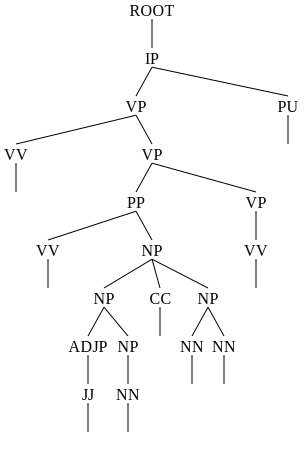

In [9]:
import svgling
svgling.draw_tree(to_linear(sent0.parseTree))

## Post processing asbc_compounds

In [10]:
import pandas as pd
npc = pd.read_csv("../data/asbc_compounds.csv", index_col=0)

In [27]:
asbc_compounds_nn2 = npc.loc[(npc.nptype==22) & ((npc.p1=="NN") & (npc.p2=="NN")), :].reset_index(drop=True)
asbc_compounds_nn2.index.name = "idx"
asbc_compounds_nn2

,np,nptype,w1,w2,p1,p2,freq
idx,,,,,,,
0,领袖会议,22,领袖,会议,NN,NN,28
1,研究人员,22,研究,人员,NN,NN,21
2,活动中心,22,活动,中心,NN,NN,20
3,学术研究,22,学术,研究,NN,NN,14
4,领域名称,22,领域,名称,NN,NN,13
...,...,...,...,...,...,...,...
2831,竞选文宣,22,竞选,文宣,NN,NN,1
2832,大学诗乡,22,大学,诗乡,NN,NN,1
2833,主管时间,22,主管,时间,NN,NN,1


In [28]:
asbc_compounds_nn2.to_csv("../data/asbc_compounds_nn2.csv")